# APC Model Construction

In [ ]:
import torch
import torch.nn as nn
import numpy as np
# import torchvision

INPUT_SIZE = 40
HIDDEN_SIZE = 512  # units inside the lstm
# DROP_RATE = 0.2  # drop-out rate
LAYERS = 1  # number of lstm layers, will be increased to 4


class toy_lstm(nn.Module):
    def __init__(self):
        super(toy_lstm, self).__init__()

        self.rnn = nn.LSTM(
            input_size=INPUT_SIZE,
            hidden_size=HIDDEN_SIZE,
            num_layers=LAYERS,
#             dropout=DROP_RATE,
            batch_first=True
        )
        self.fc = nn.Linear(HIDDEN_SIZE, 40)  # fully connected layer
        self.h_s = None
        self.h_c = None

    def forward(self, x):
        r_out, (h_s, h_c) = self.rnn(x)
        output = self.fc(r_out)
        return output

In [14]:
# import kaldiark

# # Read data index from the total scp file

# count = 0

# with open('./data/raw_fbank_train_si284.1.scp', 'rb') as scp_file:  # use '../remote/data/wsj/fbank/' replace '/data/'
#     lines = scp_file.readlines()
#     for line in lines: # line is like b'4avc040p /home/htang2/kaldi/wsj/fbank/raw_fbank_train_si284.10.ark:2769059\n'
#         temp = str(line).split()[1]
#         print(temp)
#         file_loc = temp.split(':')[0][28:]  # ark file path; keep [18:]
#         pointer = temp.split(':')[1][:-3].replace('\\r', '')  # pointer to the utterance
#         print(file_loc)
#         print(pointer)

#         # According to the file name and pointer to get the matrix
#         with open('./data' + file_loc, 'rb') as ark_file:  # use '../remote/data' + file_loc replace './data/' + file_loc
#             ark_file.seek(int(pointer))
#             utt_mat = kaldiark.parse_feat_matrix(ark_file)
#             print(utt_mat.shape)  
        
#         count = count + 1
#         if count > 10:
#             break

In [59]:
import torch
import torch.nn as nn
import numpy as np

import kaldiark
from apc import toy_lstm
import glob

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # 

LEARNING_RATE = 0.005
EPOCH = 60

rnn = toy_lstm().to(device)  
optimizer = torch.optim.Adam(rnn.parameters(), lr=LEARNING_RATE)  # optimize all parameters
loss_func = nn.MSELoss()
# Learning rate decay schedule
mult_step_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                           milestones=[EPOCH // 2, EPOCH // 4 * 3], gamma=0.1)

# Predefine the prediction gap
K = 2  # predefine the gap

# Train + Dev
train_loss = []
valid_loss = []
min_valid_loss = np.inf
for i in range(EPOCH):
    total_train_loss = []
    rnn.train()  # Training
    
    # Use the total scp files
    # Read data index from the total scp file
    with open('./data/raw_fbank_train_si284.1.scp', 'rb') as scp_file:
        lines = scp_file.readlines()
        for line in lines[:2]:  # use 2 utt to test
            temp = str(line).split()[1]
            file_loc = temp.split(':')[0][28:]  # ark file path; keep [18:]
            pointer = temp.split(':')[1][:-3].replace('\\r', '')  # pointer to the utterance
#             print(file_loc, pointer)

            # According to the file name and pointer to get the matrix
            with open('./data' + file_loc, 'rb') as ark_file:
                ark_file.seek(int(pointer))
                utt_mat = kaldiark.parse_feat_matrix(ark_file)
            
                utt_mat = np.expand_dims(utt_mat, axis=0)  # expand a new dimension as batch
                utt_mat = torch.Tensor(utt_mat).to(device)   # change data to tensor
                output = rnn(utt_mat[:, :-K, :])
                
#                 print(utt_mat.shape, output.shape)

                loss = loss_func(output, utt_mat[:, K:, :])  # compute the difference
                optimizer.zero_grad()  # clear gradients for this training step
                loss.backward()  # back-prop
                optimizer.step()  # gradients
                total_train_loss.append(loss.item())
        train_loss.append(np.mean(total_train_loss))
    # print('train complete!')

    total_valid_loss = []
    rnn.eval()  # Validation
    
    # Use one of scp files
    # Read data index from the total scp file
    with open('./data/raw_fbank_train_si284.2.scp', 'rb') as scp_file:  # change 1 to dev 
        lines = scp_file.readlines()
        for line in lines[:3]:
            temp = str(line).split()[1]
            file_loc = temp.split(':')[0][28:]  # ark file path; keep [18:]
            pointer = temp.split(':')[1][:-3].replace('\\r', '')  # pointer to the utterance

            # According to the file name and pointer to get the matrix
            with open('./data' + file_loc, 'rb') as ark_file:
                ark_file.seek(int(pointer))
                utt_mat = kaldiark.parse_feat_matrix(ark_file)
            
                utt_mat = np.expand_dims(utt_mat, axis=0)  # expand a new dimension as batch
                utt_mat = torch.Tensor(utt_mat).to(device)   # change data to tensor

                with torch.no_grad():
                    output = rnn(utt_mat[:, :-K, :])  # rnn output
                    
#                     print(utt_mat_mat.shape, output.shape)

                loss = loss_func(output, utt_mat[:, K:, :])
            total_valid_loss.append(loss.item())
        valid_loss.append(np.mean(total_valid_loss))
    # print('dev complete!')
    
    # save the net

    min_valid_loss = np.min(valid_loss)
    
    if ((i + 1) % 10 == 0):
        torch.save({'epoch': i + 1, 'state_dict': rnn.state_dict(), 'train_loss': train_loss,
                    'valid_loss': valid_loss, 'optimizer': optimizer.state_dict()},
                    './model/Epoch{:d}.pth.tar'.format((i + 1), min_valid_loss))
    

    # Log
    log_string = ('iter: [{:d}/{:d}], train_loss: {:0.6f}, valid_loss: {:0.6f}, '
                  'best_valid_loss: {:0.6f}, lr: {:0.7f}').format((i + 1), EPOCH,
                                                                  train_loss[-1],
                                                                  valid_loss[-1],
                                                                  min_valid_loss,
                                                                  optimizer.param_groups[0]['lr'])
    mult_step_scheduler.step()  # 学习率更新
    print(log_string)  # 打印日志

iter: [1/60], train_loss: 185.335281, valid_loss: 107.390554, best_valid_loss: 107.390554, lr: 0.0050000
iter: [2/60], train_loss: 118.975380, valid_loss: 66.732348, best_valid_loss: 66.732348, lr: 0.0050000
iter: [3/60], train_loss: 74.532879, valid_loss: 37.939902, best_valid_loss: 37.939902, lr: 0.0050000
iter: [4/60], train_loss: 42.338984, valid_loss: 21.579492, best_valid_loss: 21.579492, lr: 0.0050000
iter: [5/60], train_loss: 22.557779, valid_loss: 16.344495, best_valid_loss: 16.344495, lr: 0.0050000
iter: [6/60], train_loss: 13.814932, valid_loss: 19.274874, best_valid_loss: 16.344495, lr: 0.0050000
iter: [7/60], train_loss: 13.090472, valid_loss: 26.252875, best_valid_loss: 16.344495, lr: 0.0050000
iter: [8/60], train_loss: 16.465832, valid_loss: 33.299493, best_valid_loss: 16.344495, lr: 0.0050000
iter: [9/60], train_loss: 20.382216, valid_loss: 37.702118, best_valid_loss: 16.344495, lr: 0.0050000
iter: [10/60], train_loss: 22.570373, valid_loss: 38.490917, best_valid_loss: 

In [60]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt  
matplotlib.use('Agg')
y = train_loss
x = np.arange(0,len(train_loss))
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(x,y,'r--',label='type1')

ax.set_title('Loss',fontsize=18)
ax.set_xlabel('epoch', fontsize=18,fontfamily = 'sans-serif',fontstyle='italic')
ax.set_ylabel('loss', fontsize='x-large',fontstyle='oblique')
ax.legend()

plt.savefig("loss.pdf")

In [51]:
def load_model(path, model, optimizer):
    
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer

PATH = './model/Epoch60.pth.tar'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 对照-使用默认参数
rnn_raw = toy_lstm().to(device)
optimizer_raw = torch.optim.Adam(rnn.parameters(), lr=LEARNING_RATE)  # optimize all parameters

# 使用预训练参数
rnn_pretrain = toy_lstm().to(device)
optimizer_pretrain = torch.optim.Adam(rnn.parameters(), lr=LEARNING_RATE)  # optimize all parameters
rnn_pretrain, optimizer_pretrain = load_model(PATH, rnn_pretrain, optimizer_pretrain)

rnn_pretrain.eval()
rnn_raw.eval()

# get 2 utt mats:
# Predefine the prediction gap
K = 2  # predefine the gap

ori_mat = []
pre_mat = []
with open('./data/raw_fbank_train_si284.1.scp', 'rb') as scp_file:
    lines = scp_file.readlines()
    # for line in lines[:2]:  # use 1 utt to test
    temp = str(lines[0]).split()[1]
    file_loc = temp.split(':')[0][28:]  # ark file path; keep [18:]
    pointer = temp.split(':')[1][:-3].replace('\\r', '')  # pointer to the utterance

    # According to the file name and pointer to get the matrix
    with open('./data' + file_loc, 'rb') as ark_file:
        ark_file.seek(int(pointer))
        utt_mat = kaldiark.parse_feat_matrix(ark_file)
            
        utt_mat = np.expand_dims(utt_mat, axis=0)  # expand a new dimension as batch
        utt_mat = torch.Tensor(utt_mat).to(device)   # change data to tensor
        
        output_raw = rnn_raw(utt_mat[:, :-K, :])
        output_pretrain = rnn_pretrain(utt_mat[:, :-K, :])
                
        ori_mat.append(utt_mat[0, :-K, :])
        pre_mat.append(output_raw[0])
        pre_mat.append(output_pretrain[0])


In [52]:
m1 = ori_mat[0].numpy()

In [53]:
m2 = pre_mat[0].detach().numpy()

In [54]:
m3 = pre_mat[1].detach().numpy()

In [55]:
import numpy as np
import matplotlib.pyplot as plt


# Save Image Function
fig = plt.figure(figsize=(10,8))
ax = plt.gca()
cax = plt.imshow(m1, cmap='viridis')
# # set up colorbar
# cbar = plt.colorbar(cax, extend='both', drawedges = False)
# cbar.set_label('Intensity',size=36, weight =  'bold')
# cbar.ax.tick_params( labelsize=18 )
# cbar.minorticks_on()
# # set up axis labels
# ticks=np.arange(0,m1.shape[0],1)
# ## For x ticks
# plt.xticks(ticks, fontsize=12, fontweight = 'bold')
# ax.set_xticklabels(ticks)
# ## For y ticks
# plt.yticks(ticks, fontsize=12, fontweight = 'bold')
# ax.set_yticklabels(ticks)
plt.savefig('origin.png', dpi = 300)

In [56]:
# Save Image Function
fig = plt.figure(figsize=(10,8))
ax = plt.gca()
cax = plt.imshow(m2, cmap='viridis')
plt.savefig('raw.png', dpi = 300)

In [57]:
# Save Image Function
fig = plt.figure(figsize=(10,8))
ax = plt.gca()
cax = plt.imshow(m3, cmap='viridis')
plt.savefig('pretrained.png', dpi = 300)

In [24]:
print(utt_mat[0])
print(ori_mat[0])
print(pre_mat[0])
print(pre_mat[1])

tensor([[ 3.9013,  3.5482,  3.9370,  ..., 12.6050, 12.6487, 12.5332],
        [ 3.8091,  3.2036,  3.6625,  ..., 12.8245, 12.6994, 12.1048],
        [ 4.3622,  3.4333,  4.2115,  ..., 12.7971, 12.9021, 12.0844],
        ...,
        [ 4.1779,  3.2036,  3.3879,  ..., 12.6324, 12.7501, 11.7375],
        [ 3.8091,  2.1698,  3.7997,  ..., 12.7971, 12.3445, 11.7579],
        [ 3.3482,  3.0887,  3.3879,  ..., 13.0715, 13.1809, 12.4312]])
tensor([[ 3.9013,  3.5482,  3.9370,  ..., 12.6050, 12.6487, 12.5332],
        [ 3.8091,  3.2036,  3.6625,  ..., 12.8245, 12.6994, 12.1048],
        [ 4.3622,  3.4333,  4.2115,  ..., 12.7971, 12.9021, 12.0844],
        ...,
        [ 3.9013,  4.3522,  3.1134,  ..., 12.8245, 12.6233, 12.3904],
        [ 3.7170,  4.6968,  4.6233,  ..., 12.9343, 12.9528, 12.4108],
        [ 4.1779,  3.2036,  3.3879,  ..., 12.6324, 12.7501, 11.7375]])
tensor([[-0.0204, -0.0401,  0.1698,  ...,  0.0237, -0.0143,  0.0480],
        [ 0.0033, -0.0277,  0.1911,  ...,  0.0355, -0.0017,  0

In [7]:
load_dict = torch.load('./model/Epoch30.pth.tar')['state_dict']
print(load_dict.keys())
print(type(load_dict))

odict_keys(['rnn.weight_ih_l0', 'rnn.weight_hh_l0', 'rnn.bias_ih_l0', 'rnn.bias_hh_l0', 'fc.weight', 'fc.bias'])
<class 'collections.OrderedDict'>


# Probing Task Model construction

In [8]:
import torch
import torch.nn as nn
import numpy as np
class classification_net(torch.nn.Module):  
    def __init__(self, input_size, hidden_size, output_size):  
        super(classification_net, self).__init__()  
        self.hidden_layer = torch.nn.Linear(input_size, hidden_size)  
        self.out = torch.nn.Linear(hidden_size, output_size)  
    def forward(self, x):  
        x = torch.relu(self.hidden_layer(x))  
        x = self.out(x) 
        x = torch.nn.functional.softmax(x)  
        return x  

In [9]:
net = classification_net(input_size=40, hidden_size=512, output_size=2)  
print(net)  
optimizer = torch.optim.SGD(net.parameters(), lr=0.02)  
loss_func = torch.nn.CrossEntropyLoss() 

classification_net(
  (hidden_layer): Linear(in_features=40, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=2, bias=True)
)


One hot

In [23]:
import numpy as np

with open('./data/phones-unk.txt', 'r') as ph_file:
    standard = ph_file.read().splitlines()
    print(standard)



['unk', 'aa', 'ae', 'ah', 'ao', 'aw', 'ay', 'b', 'ch', 'd', 'dh', 'eh', 'er', 'ey', 'f', 'g', 'hh', 'ih', 'iy', 'jh', 'k', 'l', 'm', 'n', 'ng', 'nsn', 'ow', 'oy', 'p', 'r', 's', 'sh', 'sil', 'spn', 't', 'th', 'uh', 'uw', 'v', 'w', 'y', 'z', 'zh']


In [57]:
# para prep
HIDDEN_SIZE = 40  # WILL BE USE 512
OUTPUT_SIZE = 43
LEARNING_RATE = 0.001
EPOCH = 20
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # 

# classifier use representation dimension as input size -- i.e. HIDDEN_SIZE
classifier = classification_net(input_size=HIDDEN_SIZE, hidden_size=HIDDEN_SIZE, output_size=OUTPUT_SIZE).to(DEVICE)  
# print(net)  
optimizer = torch.optim.Adam(classifier.parameters(), lr=LEARNING_RATE)  # optimize all parameters
# Learning rate decay schedule
mult_step_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                           milestones=[EPOCH // 2, EPOCH // 4 * 3], gamma=0.1)
loss_func = torch.nn.CrossEntropyLoss()

import kaldiark
bpali_file = open('./data/train-si284.bpali', 'rb')
fbank_scp = open('./data/si284-0.9-train.fbank.scp', 'rb')
fbank_lines = fbank_scp.readlines()


# Train + Dev
train_loss = []
valid_loss = []
min_valid_loss = np.inf
for i in range(EPOCH):
    total_train_loss = []
    classifier.train()  # Training
    
    with open('./data/si284-0.9-train.bpali.scp', 'rb') as scp_file:
        bpali_lines = scp_file.readlines()
        for idx,line in enumerate(bpali_lines[:3]):
            # Find the label
            temp = str(line).split()[1]
            pointer = temp.split(':')[1][:-3].replace('\\r', '')  # pointer to the label
            # Linux only has \n
            bpali_file.seek(int(pointer))
            transcript = bpali_file.readline()
            labels = str(transcript)[2:-3].split()
#             print(str(transcript)[2:-3])

            # Find the utterance
            utt_line = fbank_lines[idx]
            temp = str(utt_line).split()[1]
            utt_file_loc = temp.split(':')[0][24:]  # ark file path; keep [14:]
            utt_pointer = temp.split(':')[1][:-3].replace('\\r', '')  # pointer to the utterance
            # print(file_loc, pointer)
            # According to the file name and pointer to get the matrix
            with open('./data' + utt_file_loc, 'rb') as ark_file:
                ark_file.seek(int(utt_pointer))
                utt_mat = kaldiark.parse_feat_matrix(ark_file)
                utt_mat = torch.Tensor(utt_mat).to(DEVICE)   # change data to tensor
#                 utt_mat = np.expand_dims(utt_mat, axis=0)  # expand a new dimension as batch
#             print(utt_mat.shape)

                for idx,mat in enumerate(utt_mat):
                    mat = torch.unsqueeze(mat, 0)
                    x = mat.to(DEVICE)
                    y = standard.index(labels[idx])
                    y = torch.tensor([y], dtype=torch.long).to(DEVICE)
                
                    optimizer.zero_grad()
                    output=classifier(x)
                    loss=loss_func(output,y) 
                    
                    loss.backward() 
                    optimizer.step() 
                    total_train_loss.append(loss.item())
        train_loss.append(np.mean(total_train_loss))

    total_valid_loss = []
    classifier.eval()  # Validation
    
    with open('./data/si284-0.9-train.bpali.scp', 'rb') as scp_file:
        bpali_lines = scp_file.readlines()
        for idx,line in enumerate(bpali_lines[:1]):
            # Find the label
            temp = str(line).split()[1]
            pointer = temp.split(':')[1][:-3].replace('\\r', '')  # pointer to the label
            # Linux only has \n
            bpali_file.seek(int(pointer))
            transcript = bpali_file.readline()
            labels = str(transcript)[2:-3].split()
#             print(str(transcript)[2:-3])

            # Find the utterance
            utt_line = fbank_lines[idx]
            temp = str(utt_line).split()[1]
            utt_file_loc = temp.split(':')[0][24:]  # ark file path; keep [14:]
            utt_pointer = temp.split(':')[1][:-3].replace('\\r', '')  # pointer to the utterance
            # print(file_loc, pointer)
            # According to the file name and pointer to get the matrix
            with open('./data' + utt_file_loc, 'rb') as ark_file:
                ark_file.seek(int(utt_pointer))
                utt_mat = kaldiark.parse_feat_matrix(ark_file)  
                utt_mat = torch.Tensor(utt_mat).to(DEVICE)   # change data to tensor
#                 utt_mat = np.expand_dims(utt_mat, axis=0)  # expand a new dimension as batch
#             print(utt_mat.shape)

                for idx,mat in enumerate(utt_mat):
                    mat = torch.unsqueeze(mat, 0)
                    x = mat.to(DEVICE)
                    y = standard.index(labels[idx])
                    y = torch.tensor([y], dtype=torch.long).to(DEVICE)
                
                    with torch.no_grad():
                        output = classifier(x)
                    loss=loss_func(output,y) 
                    total_valid_loss.append(loss.item())
        valid_loss.append(np.mean(total_valid_loss))   
    
    # save the net

    min_valid_loss = np.min(valid_loss)
    
    if ((i + 1) % 1 == 0):
        torch.save({'epoch': i + 1, 'state_dict': classifier.state_dict(), 'train_loss': train_loss,
                    'valid_loss': valid_loss, 'optimizer': optimizer.state_dict()},
                    './model_classifier/Epoch{:d}.pth.tar'.format((i + 1), min_valid_loss))
    

    # Log
    log_string = ('iter: [{:d}/{:d}], train_loss: {:0.6f}, valid_loss: {:0.6f}, '
                  'best_valid_loss: {:0.6f}, lr: {:0.7f}').format((i + 1), EPOCH,
                                                                  train_loss[-1],
                                                                  valid_loss[-1],
                                                                  min_valid_loss,
                                                                  optimizer.param_groups[0]['lr'])
    mult_step_scheduler.step()  # 学习率更新
    print(log_string)  # 打印日志
    
bpali_file.close()
fbank_scp.close()

/home/zhou/anaconda3/envs/fyp/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


iter: [1/20], train_loss: 3.763740, valid_loss: 3.774309, best_valid_loss: 3.774309, lr: 0.0010000
iter: [2/20], train_loss: 3.781741, valid_loss: 3.774309, best_valid_loss: 3.774309, lr: 0.0010000
iter: [3/20], train_loss: 3.754421, valid_loss: 3.716027, best_valid_loss: 3.716027, lr: 0.0010000
iter: [4/20], train_loss: 3.724160, valid_loss: 3.716027, best_valid_loss: 3.716027, lr: 0.0010000
iter: [5/20], train_loss: 3.724160, valid_loss: 3.716027, best_valid_loss: 3.716027, lr: 0.0010000
iter: [6/20], train_loss: 3.724160, valid_loss: 3.716027, best_valid_loss: 3.716027, lr: 0.0010000
iter: [7/20], train_loss: 3.724160, valid_loss: 3.716027, best_valid_loss: 3.716027, lr: 0.0010000
iter: [8/20], train_loss: 3.724160, valid_loss: 3.716027, best_valid_loss: 3.716027, lr: 0.0010000
iter: [9/20], train_loss: 3.724160, valid_loss: 3.716027, best_valid_loss: 3.716027, lr: 0.0010000
iter: [10/20], train_loss: 3.737266, valid_loss: 3.778910, best_valid_loss: 3.716027, lr: 0.0010000
iter: [11

Read bpali data & fbank data

In [20]:
import kaldiark
bpali_file = open('./data/train-si284.bpali', 'rb')
fbank_scp = open('./data/si284-0.9-train.fbank.scp', 'rb')
fbank_lines = fbank_scp.readlines()
with open('./data/si284-0.9-train.bpali.scp', 'rb') as scp_file:
    bpali_lines = scp_file.readlines()
    for i,line in enumerate(bpali_lines[:3]):
        # Find the label
        temp = str(line).split()[1]
        pointer = temp.split(':')[1][:-3].replace('\\r', '')  # pointer to the label
        # Linux only has \n
        bpali_file.seek(int(pointer))
        transcript = bpali_file.readline()
        # print(str(transcript)[2:-3])
#         # Windows contain \r\n instead of \n
#         bpali_file.seek(int(pointer)-1)
#         transcript = str(bpali_file.readlines()[1])[2:-3].replace('\\r', '')
#         out_list = transcript.split()
#         print(out_list)

        # Find the utterance
        utt_line = fbank_lines[i]
        temp = str(utt_line).split()[1]
        utt_file_loc = temp.split(':')[0][24:]  # ark file path; keep [14:]
        utt_pointer = temp.split(':')[1][:-3].replace('\\r', '')  # pointer to the utterance
        # print(file_loc, pointer)
        # According to the file name and pointer to get the matrix
        with open('./data' + utt_file_loc, 'rb') as ark_file:
            ark_file.seek(int(utt_pointer))
            utt_mat = kaldiark.parse_feat_matrix(ark_file)         
            utt_mat = np.expand_dims(utt_mat, axis=0)  # expand a new dimension as batch
            print(utt_mat.shape)

bpali_file.close()
fbank_scp.close()

(1, 652, 40)
(1, 693, 40)
(1, 1069, 40)


Run the linear classifier

In [ ]:



# para prep
HIDDEN_SIZE = 40  # WILL BE USE 512
OUTPUT_SIZE = 43
LEARNING_RATE = 0.001
EPOCH = 20
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # 

# classifier use representation dimension as input size -- i.e. HIDDEN_SIZE
classifier = classification_net(input_size=HIDDEN_SIZE, hidden_size=HIDDEN_SIZE, output_size=OUTPUT_SIZE).to(DEVICE)  
# print(net)  
optimizer = torch.optim.Adam(classifier.parameters(), lr=LEARNING_RATE)  # optimize all parameters
# Learning rate decay schedule
mult_step_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                           milestones=[EPOCH // 2, EPOCH // 4 * 3], gamma=0.1)
loss_func = torch.nn.CrossEntropyLoss()


# Train + Dev
train_loss = []
valid_loss = []
min_valid_loss = np.inf
for i in range(EPOCH):
    total_train_loss = []
    rnn.train()  # Training
    
    
    
    
    
    

    for idx, (images,labels) in enumerate(train_dataloader):
        x =images.reshape(-1,28*28)

        x=x.to(DEVICE)# 如果用CPU去掉
        labels=labels.to(DEVICE)# 如果用CPU去掉

        optimizer.zero_grad() #梯度清零
        preds=fc(x) #计算预测
        loss=loss_func(preds,labels) #计算损失
        loss.backward() # 计算参数梯度
        optimizer.step() # 更新迭代梯度
    
    
    
    
    # Use the total scp files
    # Read data index from the total scp file
    with open('./data/raw_fbank_train_si284.1.scp', 'rb') as scp_file:
        lines = scp_file.readlines()
        for line in lines[:2]:  # use 2 utt to test
            temp = str(line).split()[1]
            file_loc = temp.split(':')[0][28:]  # ark file path; keep [18:]
            pointer = temp.split(':')[1][:-3].replace('\\r', '')  # pointer to the utterance
#             print(file_loc, pointer)

            # According to the file name and pointer to get the matrix
            with open('./data' + file_loc, 'rb') as ark_file:
                ark_file.seek(int(pointer))
                utt_mat = kaldiark.parse_feat_matrix(ark_file)
            
                utt_mat = np.expand_dims(utt_mat, axis=0)  # expand a new dimension as batch
                utt_mat = torch.Tensor(utt_mat).to(DEVICE)   # change data to tensor
                output = rnn(utt_mat[:, :-K, :])
                
#                 print(utt_mat.shape, output.shape)

                loss = loss_func(output, utt_mat[:, K:, :])  # compute the difference
                optimizer.zero_grad()  # clear gradients for this training step
                loss.backward()  # back-prop
                optimizer.step()  # gradients
                total_train_loss.append(loss.item())
        train_loss.append(np.mean(total_train_loss))
    # print('train complete!')

    total_valid_loss = []
    rnn.eval()  # Validation
    
    # Use one of scp files
    # Read data index from the total scp file
    with open('./data/raw_fbank_train_si284.2.scp', 'rb') as scp_file:  # change 1 to dev 
        lines = scp_file.readlines()
        for line in lines[:3]:
            temp = str(line).split()[1]
            file_loc = temp.split(':')[0][28:]  # ark file path; keep [18:]
            pointer = temp.split(':')[1][:-3].replace('\\r', '')  # pointer to the utterance

            # According to the file name and pointer to get the matrix
            with open('./data' + file_loc, 'rb') as ark_file:
                ark_file.seek(int(pointer))
                utt_mat = kaldiark.parse_feat_matrix(ark_file)
            
                utt_mat = np.expand_dims(utt_mat, axis=0)  # expand a new dimension as batch
                utt_mat = torch.Tensor(utt_mat).to(device)   # change data to tensor

                with torch.no_grad():
                    output = rnn(utt_mat[:, :-K, :])  # rnn output
                    
#                     print(utt_mat_mat.shape, output.shape)

                loss = loss_func(output, utt_mat[:, K:, :])
            total_valid_loss.append(loss.item())
        valid_loss.append(np.mean(total_valid_loss))
    # print('dev complete!')
    
    # save the net

    min_valid_loss = np.min(valid_loss)
    
    if ((i + 1) % 10 == 0):
        torch.save({'epoch': i + 1, 'state_dict': rnn.state_dict(), 'train_loss': train_loss,
                    'valid_loss': valid_loss, 'optimizer': optimizer.state_dict()},
                    './model_classifier/Epoch{:d}.pth.tar'.format((i + 1), min_valid_loss))
    

    # Log
    log_string = ('iter: [{:d}/{:d}], train_loss: {:0.6f}, valid_loss: {:0.6f}, '
                  'best_valid_loss: {:0.6f}, lr: {:0.7f}').format((i + 1), EPOCH,
                                                                  train_loss[-1],
                                                                  valid_loss[-1],
                                                                  min_valid_loss,
                                                                  optimizer.param_groups[0]['lr'])
    mult_step_scheduler.step()  # 学习率更新
    print(log_string)  # 打印日志

In [6]:
import torch
import torch.nn as nn
import numpy as np
from functions import load_model
from apc import toy_lstm
import kaldiark
import matplotlib.pyplot as plt

PATH = './model/Epoch1.pth.tar'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

INPUT_SIZE = 40
HIDDEN_SIZE = 512
LAYERS = 4
LEARNING_RATE = 0.001

# 对照-使用默认参数
rnn_raw = toy_lstm(INPUT_SIZE=INPUT_SIZE, HIDDEN_SIZE=HIDDEN_SIZE, LAYERS=LAYERS).to(device)
optimizer_raw = torch.optim.Adam(rnn_raw.parameters(), lr=LEARNING_RATE)  # optimize all parameters

# 使用预训练参数
rnn_pretrain = toy_lstm(INPUT_SIZE=INPUT_SIZE, HIDDEN_SIZE=HIDDEN_SIZE, LAYERS=LAYERS).to(device)
optimizer_pretrain = torch.optim.Adam(rnn_pretrain.parameters(), lr=LEARNING_RATE)  # optimize all parameters
rnn_pretrain, optimizer_pretrain = load_model(PATH, rnn_pretrain, optimizer_pretrain)

rnn_pretrain.eval()
rnn_raw.eval()

# get 2 utt mats:
# Predefine the prediction gap
K = 2  # predefine the gap

ori_mat = []
pre_mat = []
with open('./data/raw_fbank_train_si284.1.scp', 'rb') as scp_file:
    # mlp use: './data/raw_fbank_train_si284.1.scp'
    # win use: './data/raw_fbank_train_si284.1.scp'
    lines = scp_file.readlines()
    # for line in lines[:2]:  # use 1 utt to test
    temp = str(lines[0]).split()[1]
    file_loc = temp.split(':')[0][28:]  # ark file path; keep [18:]
    pointer = temp.split(':')[1][:-3].replace('\\r', '')  # pointer to the utterance

    # According to the file name and pointer to get the matrix
    with open('./data' + file_loc, 'rb') as ark_file:
        ark_file.seek(int(pointer))
        utt_mat = kaldiark.parse_feat_matrix(ark_file)

        utt_mat = np.expand_dims(utt_mat, axis=0)  # expand a new dimension as batch
        utt_mat = torch.Tensor(utt_mat).to(device)   # change data to tensor

        output_raw = rnn_raw(utt_mat[:, :-K, :])
        output_pretrain = rnn_pretrain(utt_mat[:, :-K, :])

        ori_mat.append(utt_mat[0, :-K, :])
        pre_mat.append(output_raw[0])
        pre_mat.append(output_pretrain[0])

m1 = ori_mat[0].cpu().numpy()
m2 = pre_mat[0].cpu().detach().numpy()
m3 = pre_mat[1].cpu().detach().numpy()

cpu


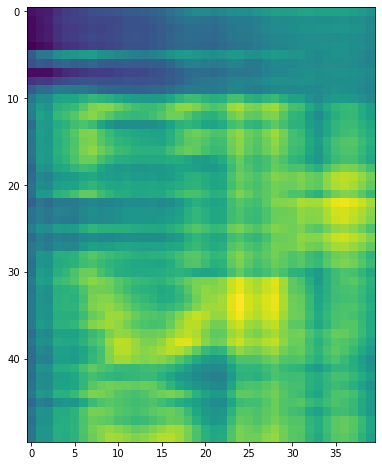

In [7]:
# Save Image Function
fig = plt.figure(figsize=(10,8))
ax = plt.gca()
cax = plt.imshow(m1[50:100], cmap='viridis')
plt.savefig('origin.pdf')

cax = plt.imshow(m2[50:100], cmap='viridis')
plt.savefig('raw.pdf')

cax = plt.imshow(m3[50:100], cmap='viridis')
plt.savefig('pretrained.pdf')

check the pre-train model's previous layer parameters

In [7]:
import torch
import torch.nn as nn
import numpy as np
from functions import load_model
from apc import toy_lstm
import kaldiark
import matplotlib.pyplot as plt

PATH = './model/Epoch1.pth.tar'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

INPUT_SIZE = 40
HIDDEN_SIZE = 512
LAYERS = 4
LEARNING_RATE = 0.001

# 使用预训练参数
rnn_pretrain = toy_lstm(INPUT_SIZE=INPUT_SIZE, HIDDEN_SIZE=HIDDEN_SIZE, LAYERS=LAYERS).to(device)
optimizer_pretrain = torch.optim.Adam(rnn_pretrain.parameters(), lr=LEARNING_RATE)  # optimize all parameters
rnn_pretrain, optimizer_pretrain = load_model(PATH, rnn_pretrain, optimizer_pretrain)

rnn_pretrain.eval()

model2 = nn.Sequential(*list(rnn_pretrain.children())[:1])
model2.eval()


cpu


Sequential(
  (0): LSTM(40, 512, num_layers=4, batch_first=True)
)